# Tensorflow 1.15 - Keras 2.2.4

In [ ]:
!pip install tensorflow==1.15

In [ ]:
!pip install Keras==2.2.4

In [3]:
import tensorflow as tf

In [4]:
import keras

Using TensorFlow backend.


In [5]:
print(tf.__version__)

1.15.0


In [6]:
print(tf.keras.__version__)

2.2.4-tf


In [7]:
print(keras.__version__)

2.2.4


In [32]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape
from keras.layers import merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave, imshow, show
import numpy as np
import os
import random
import tensorflow as tf
from matplotlib import pyplot as plt 

In [9]:
# Get images
X = []
for filename in os.listdir('Train/'):
    X.append(img_to_array(load_img('Train/'+filename)))
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X

In [ ]:
#Load weights
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

In [11]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 128 73856       conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 64, 64, 128)  147584      conv2d_205[0][0]                 
__________________________________________________________________________________________________
conv2d_207

In [13]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

In [14]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 20

In [15]:
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 255
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)

In [47]:
#Train model      
model.compile(optimizer='adam', loss='mse')
history = model.fit_generator(image_a_b_gen(batch_size), epochs=100, steps_per_epoch=2)


Epoch 1/100
2/2 [==============================] - 38s 19s/step - loss: 0.9600
Epoch 2/100
2/2 [==============================] - 32s 16s/step - loss: 0.9601
Epoch 3/100
2/2 [==============================] - 32s 16s/step - loss: 0.9592
Epoch 4/100
2/2 [==============================] - 32s 16s/step - loss: 0.9590
Epoch 5/100
2/2 [==============================] - 32s 16s/step - loss: 0.9603
Epoch 6/100
2/2 [==============================] - 32s 16s/step - loss: 0.9611
Epoch 7/100
2/2 [==============================] - 31s 16s/step - loss: 0.9583
Epoch 8/100
2/2 [==============================] - 32s 16s/step - loss: 0.9573
Epoch 9/100
2/2 [==============================] - 31s 16s/step - loss: 0.9580
Epoch 10/100
2/2 [==============================] - 32s 16s/step - loss: 0.9581
Epoch 11/100
2/2 [==============================] - 31s 16s/step - loss: 0.9599
Epoch 12/100
2/2 [==============================] - 32s 16s/step - loss: 0.9593
Epoch 13/100
2/2 [==============================]

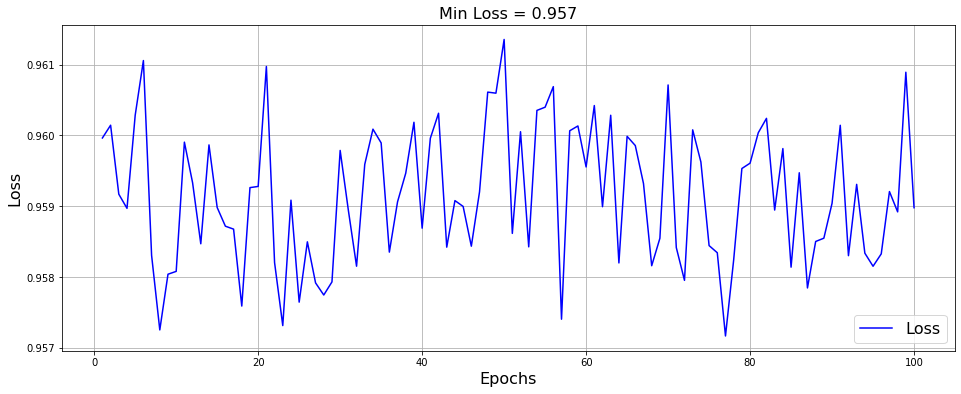

In [48]:
loss = history.history['loss']
nepochs=100
plt.figure(figsize=(16,6))
plt.plot(range(1,nepochs+1), loss, 'b', label='Loss',color="blue")

plt.title('Min Loss = ' + str(round(min(loss),3)),fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.grid(True)
plt.legend(loc = 'lower right',fontsize=16)

plt.show()

In [49]:
color_me = []
for filename in os.listdir('Test/'):
    color_me.append(img_to_array(load_img('Test/'+filename)))
color_me = np.array(color_me, dtype=float)
color_me = 1.0/255*color_me
color_me = gray2rgb(rgb2gray(color_me))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

In [50]:
# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

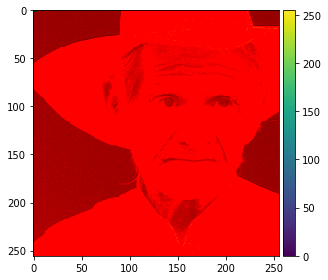

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: result/img_0.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()


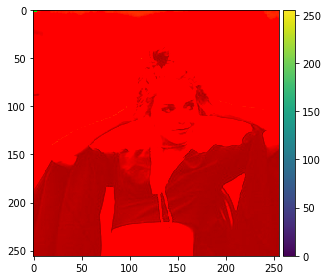

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: result/img_1.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()


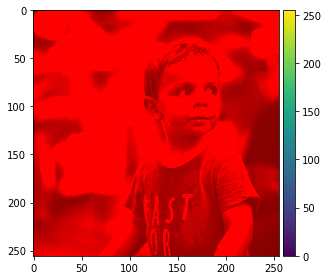

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: result/img_2.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()


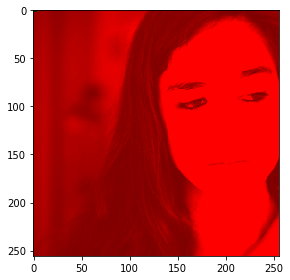

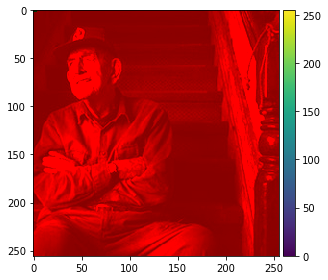

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: result/img_4.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()


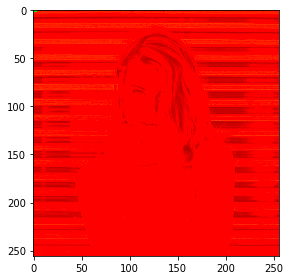

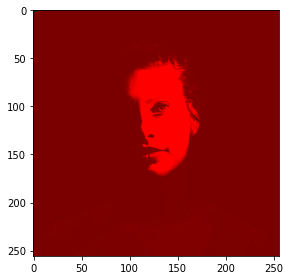

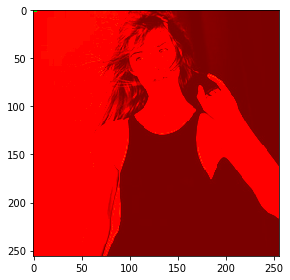

In [51]:
# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    
    colored_image = (lab2rgb(cur)*255).astype(np.uint8)
    
    imshow(colored_image)
    show()
    imsave("result/img_"+str(i)+".png", colored_image)

### Gray scale image

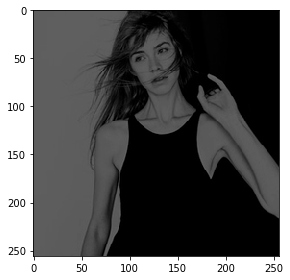

In [53]:
imshow(np.uint8(cur[:,:,0]))

## Intermediate representations

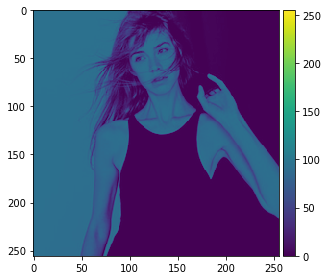

In [54]:
imshow(cur[:,:,0],  vmin=0, vmax=255)

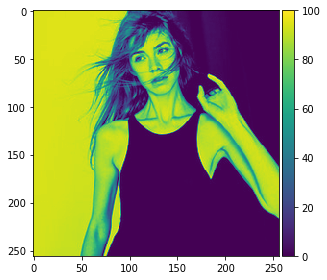

In [55]:
imshow((cur[:,:,0]))

### Output image

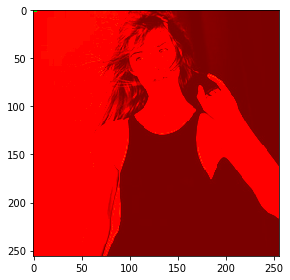

In [52]:
imshow(colored_image)